## Simmulating MinION reads with Nanosim

[NanoSim](https://github.com/bcgsc/NanoSim) is a fast and scalable read simulator that captures the technology-specific features of ONT data, and allows for adjustments upon improvement of nanopore sequencing technology.

NanoSim proceeds in two steps. In the first step, NanoSim provides a comprehensive alignment-based analysis and generates a set of read profiles (read characterization step). Whereas in the second step, it models the read features such as the base-calling errors of ONT reads and the length distribution (built in the previous step) to produce in silico reads for a given reference genome (simulation step). Although ONT chemistry is still evolving, the statistical models that NanoSim uses are theoretically valid for any version of it. At the moment, it has been tested with both the 1D reads using the R9 chemistry, and the 2D reads using the chemistry R7, R7.3 and R9. NanoSim can simulate either circular or linear genomes and is capable of simulating reads from genomes with multiple chromosomes. An important note is that the runtime and memory requirements of NanoSim are highly dependent on the number of simulated reads and the length of the reference sequence.

NanoDJ uses [Nanosim-h](https://github.com/karel-brinda/NanoSim-H), a fork from the NanoSim project, which permits moving directly to the simulation step using precomputed error profiles instead of investing time on the read characterization step. This alternative may be attractive for those users without access to ONT read-level information data.

In [1]:
!nanosim-h -h

usage: nanosim-h [-h] [-v] [-p str] [-o str] [-n int] [-u float] [-m float]
                 [-i float] [-d float] [-s int] [--circular] [--perfect]
                 [--merge-contigs] [--rnf] [--rnf-add-cigar] [--max-len int]
                 [--min-len int] [--kmer-bias int]
                 <reference.fa>

Program:  NanoSim-H - a simulator of Oxford Nanopore reads.
Version:  1.1.0.4
Authors:  Chen Yang <cheny@bcgsc.ca> - author of the original software package (NanoSim)
          Karel Brinda <kbrinda@hsph.harvard.edu> - author of the NanoSim-H fork

positional arguments:
  <reference.fa>        reference genome (- for standard input)

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit
  -p str, --profile str
                        error profile - one of precomputed profiles ('yeast',
                        'ecoli_R9_2D', 'ecoli_R7', 'ecoli_R7.3',
                        'ecoli_R9_1D', 'ecoli_UC

In [3]:
!nanosim-h -n20 NZ_CP010867.1_Ref.fasta

Using profile ecoli_R9_2D from default profiles
Simulating unaligned reads
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
Simulating aligned reads
100% (19 of 19) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [4]:
!nanosim-h -p 'ecoli_R9_1D' -n 20 -o simulated data/agalactiae/reads.fasta

Using profile ecoli_R9_1D from default profiles
Simulating unaligned reads
- |#                                                  | 0 Elapsed Time: 0:00:00
Simulating aligned reads
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Using the QualityControl.ipynb the user can generate distinct plots and tables (read length, GC content, etc) out of the simulated reads:

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


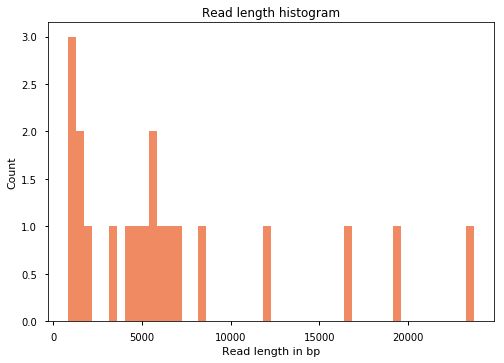

In [5]:
%load_ext rpy2.ipython

#Biopython module imports for loading sequence files
from Bio import SeqIO
from Bio.SeqUtils import GC

#Numpy and pandas to manage the data
import numpy as np
import pandas as pd

#To use regular reagular expressions for extract the read id
import re

from Bio.SeqUtils import GC

#Numpy and pandas to manage our data
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib

#We will use reagular expressions for extract the read id
import re

#Function to build a pandas dataframe from a FASTA or FASTQ file
def read_sequence_file(filename, format):
    rows = []
    columns = ['id', 'sequence', 'read_length', 'gc_content']
    if(format == 'fastq'):
        columns.append('avg_quality')
    #Building each row with the read and its features
    for seq_record in SeqIO.parse(filename, format):
        if(format == 'fastq'):
            quality_score = np.mean(seq_record.letter_annotations["phred_quality"])
        read_id = seq_record.description
        if(format == 'fastq'):
            rows.append([read_id, seq_record.seq, len(seq_record.seq), GC(seq_record.seq), quality_score])
        else:
            rows.append([read_id, seq_record.seq, len(seq_record.seq), GC(seq_record.seq)])  
        
    df = pd.DataFrame(rows, columns=columns)
    return df

# ----- Place the path to your reads file here ----- #
seq_df = read_sequence_file('simulated.fa', 'fasta')

#Setting the plot size
matplotlib.rcParams['figure.figsize'] = (9, 8)

#We can customize the plot using the pre-defined style called “ggplot” to emulate ggplot (popular R vizualization package) style 
plt.style.use('seaborn-notebook')

#On the plt.hist parameters we can set the number of bins and the bar color using labels as 'blue', 'red', 'yellow'... or using a RGB code.
#CHANGE 'read_length' FOR 'gc_content' TO PLOT GC CONTENT INSTAD OF READ LENGTH 
plt.hist(seq_df['read_length'], bins=50, color='#ef8a62')
plt.title('Read length histogram')
plt.xlabel('Read length in bp')
plt.ylabel('Count')

plt.show()

## Nanosim regular version usage

In the regular version of NanoSim, the two stages need to be executed separately. For the read characterization step, NanoSim takes a training read set in FASTA format and use minimap2 or LAST as alignment algorithm to characterize base-calling errors. An alignment file in SAM/MAF format can be provided instead of the reads. A set of read profiles is then generated and used as input in the simulation step.

Ready to use read profiles are available and can be downloaded from [Supplementary data of NanoSim](ftp://ftp.bcgsc.ca/supplementary/NanoSim/). These profiles allow users to move directly to the simulation step.This is available since the last version.

In [4]:
read_analysis.py -h

./read_analysis.py <options>
<options>: 
-h : print usage message
-i : training ONT real reads, must be fasta files
-r : reference genome of the training reads
-a : Aligner to be used: minimap2 or LAST, default = 'minimap2
-m : User can provide their own alignment file, with maf or sam extension, can be omitted
-b : number of bins (for development), default = 20
-t : number of threads for LAST alignment, default = 1
-o : The prefix of output file, default = 'training'
--no_model_fit : Skip the model fitting step


In [ ]:
read_analysis.py -i data/agalactiae/reads.fasta -r data/agalactiae/reference/NZ_CP010867.1_Ref.fasta -o agalactiae

Simulation stage takes read profiles and reference as input. The output of this stage consists of a FASTA file with the simulated reads.

In [7]:
!simulator.py -H

./simulator.py [command] <options>
[command] circular | linear
Do not choose 'circular' when there is more than one sequence in the reference
<options>: 
-h : print usage message
-r : reference genome in fasta file, specify path and file name, REQUIRED
-c : The prefix of training set profiles, same as the output prefix in read_analysis.py, default = training
-o : The prefix of output file, default = 'simulated'
-n : Number of generated reads, default = 20,000 reads
--max_len : Maximum read length, default = Inf
--min_len : Minimum read length, default = 50
--perfect: Output perfect reads, no mutations, default = False
--KmerBias: prohibits homopolymers with length >= n bases in output reads, default = 6
--seed: manually seeds the pseudo-random number generator, default = None


In [ ]:
simulator.py circular -r data/agalactiae/reference/NZ_CP010867.1_Ref.fasta -c agalactiae

### Reference:

[Chen Yang, Justin Chu, René L Warren, Inanç Birol; NanoSim: nanopore sequence read simulator based on statistical characterization. Gigascience 2017 gix010. doi: 10.1093/gigascience/gix010](https://academic.oup.com/gigascience/article/6/4/gix010/3051934)
